In [129]:
import os,re,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2019)
import xgboost as xgb
import lightgbm as lgb
#import catboost as ctb
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
#from catboost import Pool, CatBoostClassifier
from category_encoders import TargetEncoder
from scipy.special import logit

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)

%matplotlib inline


In [2]:
os.chdir('D:/hackathon/drivendata/earthquakprediction/')

In [3]:
os.listdir()

['sub1.csv',
 'sub2.csv',
 'submission_format.csv',
 'test_values.csv',
 'train_labels.csv',
 'train_valuesfeatures.csv']

In [60]:
testdf=pd.read_csv('test_values.csv')

trainfeatures=pd.read_csv('train_valuesfeatures.csv')
trainlabels=pd.read_csv('train_labels.csv')
submissiondf=pd.read_csv('submission_format.csv')

In [61]:
trainfeatures.shape,trainlabels.shape,testdf.shape

((260601, 39), (260601, 2), (86868, 39))

In [6]:
trainfeatures.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,0


In [7]:
trainlabels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [8]:
## adding lables into data

traindf=trainfeatures.merge(trainlabels,on='building_id',how='left')

In [9]:
traindf.isnull().sum()  ## no null value

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

In [10]:
traindf.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
count,2.606010e+05,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,5.256755e+05,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,...,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119,2.238272
std,3.045450e+05,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,...,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364,0.611814
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.611900e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,5.257570e+05,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,7.897620e+05,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [11]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
building_id                               260601 non-null int64
geo_level_1_id                            260601 non-null int64
geo_level_2_id                            260601 non-null int64
geo_level_3_id                            260601 non-null int64
count_floors_pre_eq                       260601 non-null int64
age                                       260601 non-null int64
area_percentage                           260601 non-null int64
height_percentage                         260601 non-null int64
land_surface_condition                    260601 non-null object
foundation_type                           260601 non-null object
roof_type                                 260601 non-null object
ground_floor_type                         260601 non-null object
other_floor_type                          260601 non-null object
position                                  260601 non

In [12]:
traindf['damage_grade'].value_counts()/len(traindf)

2    0.568912
3    0.334680
1    0.096408
Name: damage_grade, dtype: float64

In [13]:
traindf.shape,testdf.shape

((260601, 40), (86868, 39))

In [14]:
len(traindf) + len(testdf)

347469

In [62]:
#[col for col in traindf.columns if col not in testdf.columns]

testdf['damage_grade']=-1

In [63]:
totaldata=traindf.append(testdf[traindf.columns])

In [64]:
#totaldata=traindf.copy()

In [65]:
len(totaldata)

347469

In [66]:
cols_levels='land_surface_condition, foundation_type, roof_type, ground_floor_type, other_floor_type, position, plan_configuration, legal_ownership_status'.strip().split(',')
cols_levels2=' '.join(cols_levels).split()

In [67]:
dummiesdf=pd.get_dummies(totaldata[cols_levels2],drop_first=True)

In [68]:
dummiesdf.shape,totaldata.shape

((347469, 30), (347469, 40))

In [69]:
dummiesdf.head()

,land_surface_condition_o,land_surface_condition_t,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_m,ground_floor_type_v,...,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [70]:
totaldata.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,3


In [71]:
#traindf2 = pd.concat([df_a.reset_index(drop=True), df_b], axis=1)

#totaldata2=totaldata.join(dummiesdf)

totaldata2 = pd.concat([totaldata, dummiesdf], axis=1)


In [72]:
totaldata.shape,totaldata2.shape,dummiesdf.shape

((347469, 40), (347469, 70), (347469, 30))

In [73]:
totaldata2=totaldata2[[col for col in totaldata2.columns if col not in cols_levels2 ]]

In [74]:
totaldata2=totaldata2.reset_index()
del totaldata2['index']


In [75]:
traindf2=totaldata2[totaldata2['damage_grade'] != -1]
testdata=totaldata2[totaldata2['damage_grade'] == -1]

In [30]:
traindf2.shape,traindf.shape

((260601, 62), (260601, 40))

In [31]:
q=traindf2.groupby(['has_secondary_use_other'])['damage_grade'].value_counts()

In [32]:
pd.DataFrame(q)

damage_grade
has_secondary_use_other damage_grade              
0                       2                   147407
                        3                    86911
                        1                    24949
1                       2                      852
                        3                      307
                        1                      175

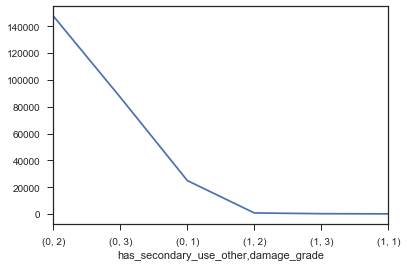

In [33]:
q.plot()

In [39]:
traindf2['damage_grade'].unique()

array([3, 2, 1], dtype=int64)

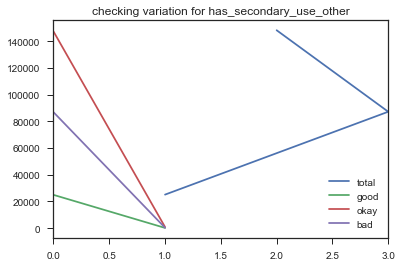

In [40]:
good=traindf2[traindf2['damage_grade']==1]['has_secondary_use_other'].value_counts()
okay=traindf2[traindf2['damage_grade']==2]['has_secondary_use_other'].value_counts()
bad=traindf2[traindf2['damage_grade']==3]['has_secondary_use_other'].value_counts()

total=traindf2['damage_grade'].value_counts()
               
# passed=loantraindata_notnull[loantraindata_notnull['Loan_Status'] == 'Y'][c].value_counts()
# rejected=loantraindata_notnull[loantraindata_notnull['Loan_Status'] == 'N'][c].value_counts()
# total=loantraindata_notnull[c].value_counts()

fig, axes = plt.subplots(nrows=1,ncols=1)
#print("checking variation for {}".format(c))

f1= total.plot(ax=axes,label='total')
f1.title.set_text("checking variation for {}".format('has_secondary_use_other'))

f2=good.plot(ax=axes,label='good')
#f2.title.set_text("checking variation for {}".format(c))
f3=okay.plot(ax=axes,label='okay')
f4=bad.plot(ax=axes,label='bad')
#f3.title.set_text("checking variation for {}".format(c))

axes.legend(loc='best')

C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


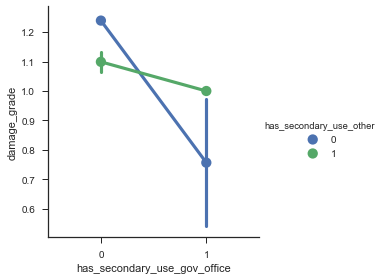

In [295]:
sns.factorplot(x="has_secondary_use_gov_office", y="damage_grade", hue="has_secondary_use_other",
            #palette={"male": "g", "female": "m"},
            #markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=traindf2);

## modeling 

In [101]:
traindf2['damage_grade']=traindf2['damage_grade'].apply(lambda x : x -1 )

C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [103]:
traindf2.iloc[:,:].head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
0,802906,6,487,12198,2,30,6,5,1,1,...,0,0,0,0,0,0,0,0,1,0
1,28830,8,900,2812,2,10,8,7,0,1,...,0,0,0,0,0,0,0,0,1,0
2,94947,21,363,8973,2,10,5,5,0,1,...,0,0,0,0,0,0,0,0,1,0
3,590882,22,418,10694,2,10,6,5,0,1,...,0,0,0,0,0,0,0,0,1,0
4,201944,11,131,1488,3,30,8,9,1,0,...,0,0,0,0,0,0,0,0,1,0


In [104]:

## for final test
x_train, x_valid, y_train, y_valid = train_test_split(traindf2.iloc[:,1:], traindf2['damage_grade'],
                                         test_size=0.01, random_state=42, stratify=traindf2['damage_grade'],shuffle=True)


In [105]:
x_train.shape,x_valid.shape

((257994, 61), (2607, 61))

In [106]:
Counter(y_valid)

Counter({1: 1483, 2: 873, 0: 251})

In [107]:
x_valid['damage_grade'].value_counts()

1    1483
2     873
0     251
Name: damage_grade, dtype: int64

In [410]:
x_valid['damage_grade'].value_counts()/len(x_valid)

1    0.568896
2    0.334676
0    0.096428
Name: damage_grade, dtype: float64

In [411]:
x_train['damage_grade'].value_counts()/len(x_train)

1    0.568914
2    0.334681
0    0.096406
Name: damage_grade, dtype: float64

In [412]:
x_train['damage_grade'].value_counts()

1    133433
2     78496
0     22611
Name: damage_grade, dtype: int64

In [413]:
x, x_test, y, y_test = train_test_split(x_train, x_train['damage_grade'],
                                         test_size=0.2, random_state=42, stratify=x_train['damage_grade'],shuffle=True)

print(x.shape,x_test.shape)


(187632, 58) (46908, 58)


In [34]:

# train_data = lgb.Dataset(x, label=y)
# test_data = lgb.Dataset(x_test, label=y_test)

# parameters = {
# #     'application': 'binary',
#     'objective': 'multiclass',
#     'metric': 'multi_logloss',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_class':3,
#     'num_leaves': 10,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.1,
#     'verbose': 1
# }

# model = lgb.train(parameters,
#                        train_data,
#                        valid_sets=test_data,
#                        num_boost_round=5000,
#                        early_stopping_rounds=10)


In [35]:
#y_true=x_valid.iloc[:30,:]['damage_grade']

In [36]:
#y_pred=model.predict([x_valid.iloc[1,:]]).argmax()

In [37]:
#y_pred=model.predict(x_valid.iloc[:30,:]).argmax(axis=1)

In [38]:
#y_true,y_pred

In [39]:
#f1_score(y_true ,y_pred, average='macro') 

In [122]:
 parameters = {
    #     'application': 'binary',
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'is_unbalance': 'true',
        'boosting': 'dart',
        'num_class':3,
        'num_leaves': 70,
        'max_depth': 10,'is_unbalance':True,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.95,
        'bagging_freq': 10,
        'learning_rate': 0.04,'xgboost_dart_mode':True,
        'lambda_l2': 0.2,
        'verbose': 1
    }

def lgbmodel(dev_X, dev_y, val_X, val_y, test, params2):
    
    train_data = lgb.Dataset(dev_X, label=dev_y)
    test_data = lgb.Dataset(val_X, label=val_y)

   
    model = lgb.train(parameters,
                           train_data,
                           valid_sets=test_data,
                           num_boost_round=100,
                           early_stopping_rounds=50)
    feature_im = model.feature_importance()
    
    print('Predict 1/2')
    pred_test_y = model.predict(val_X).argmax(axis=1)
    print('len of pred_test_y is {}'.format(pred_test_y.shape))
    print('Predict 2/2')
    pred_test_y2 = model.predict(test).argmax(axis=1)
    print('len of pred_test_y2 is {}'.format(pred_test_y2.shape))
    return pred_test_y, pred_test_y2, feature_im,model


    

In [119]:
# def runCAT(train_X, train_y, test_X, test_y, test_X2, params):
#     # Pool the data and specify the categorical feature indices
#     print('Pool Data')
#     _train = Pool(train_X, label=train_y)
#     _valid = Pool(test_X, label=test_y)    
#     print('Train CAT')
#     model = CatBoostClassifier(**params)
#     fit_model = model.fit(_train,
#                           eval_set=_valid,
#                           use_best_model=True,
#                           verbose=1000,
#                           plot=False)
#     feature_im = fit_model.feature_importances_
#     print('Predict 1/2')
#     pred_test_y = logit(fit_model.predict_proba(test_X)[:, 1])
#     print('Predict 2/2')
#     pred_test_y2 = logit(fit_model.predict_proba(test_X2)[:, 1])
#     return pred_test_y, pred_test_y2, feature_im


In [416]:
# def multi_logloss_eval()
#run_cv_model(x, x_test, x['damage_grade'], lgbmodel, parameters,log_loss, 'f1', n_folds=n_folds)

In [342]:
# kf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 228)
# fold_splits = kf.split(x, x['damage_grade'])
# cv_scores = []
# pred_full_test = 0
# pred_train = np.zeros((x.shape[0]))
# feature_importances = pd.DataFrame()
# feature_importances['feature'] = x_test.columns
# i = 1
# for dev_index, val_index in fold_splits:
#     print('-------------------------------------------')
#     #print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
#     dev_X, val_X = x.iloc[dev_index], x.iloc[val_index]
#     dev_y, val_y = x['damage_grade'].iloc[dev_index], x['damage_grade'].iloc[val_index]
#     params2 = parameters.copy()
#     pred_val_y, pred_test_y, fi = lgbmodel(dev_X, dev_y, val_X, val_y, x_test, params2)
#     print(f1_score(val_y ,pred_val_y, average='macro') )
#     i += 1
#     if i > 3:
#         break

In [343]:
#pred_val_y.shape,val_y.shape

In [344]:
#f1_score(val_y ,pred_val_y, average='macro') 

In [123]:
from sklearn.metrics import log_loss

def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None,label='model', n_folds=5):
    kf = StratifiedKFold(n_splits=n_folds, shuffle = True, random_state = 228)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = test.columns
    i = 1
    for dev_index, val_index in fold_splits:
        print('-------------------------------------------')
        print('Started ' + label + ' fold ' + str(i) + f'/{n_folds}')
        dev_X, val_X = train.iloc[dev_index], train.iloc[val_index]
        dev_y, val_y = target.iloc[dev_index], target.iloc[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y, fi,model = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        feature_importances[f'fold_{i}'] = fi
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        #if eval_fn is not None:
            #cv_score = eval_fn(val_y, pred_val_y)
        try:
            print(val_y.shape)
            print(pred_val_y.shape)
            print('f1 score is {}'.format(f1_score(val_y, pred_val_y, average='micro') ))
            cv_score=f1_score(val_y, pred_val_y, average='micro')
            print('cvscore is {}'.format(cv_score))
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score), '\n')
        except:
            print('in loop number {}'.format(i))
            
            break
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / n_folds
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores, 'fi': feature_importances}
    return results,model


# Use some baseline parameters
# cat_params = {'loss_function': 'MultiClass',  # CrossEntropy
#               'eval_metric': "MultiClass", #multi_logloss
#               'learning_rate': 0.05,
#               'classes_count' : 3,
#               'iterations': 50000,
#               'random_seed': 42,
#               'od_type': "Iter",
#               'early_stopping_rounds': 200,
#              }




In [124]:
from sklearn.metrics import log_loss
#log_loss(["spam", "ham", "ham", "spam"],[[.1, .9], [.9, .1], [.8, .2], [.35, .65]])

In [125]:
colneeded=[f for f in x_train.columns if f not in ['damage_grade']]

In [126]:
n_folds = 10
results,model = run_cv_model(x_train[colneeded], x_valid[colneeded], x_train['damage_grade'], lgbmodel, parameters,f1_score, 'f1', n_folds=n_folds)


-------------------------------------------
Started f1 fold 1/10
[1]	valid_0's multi_logloss: 0.901981
[2]	valid_0's multi_logloss: 0.888867


C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[3]	valid_0's multi_logloss: 0.876888
[4]	valid_0's multi_logloss: 0.868385
[5]	valid_0's multi_logloss: 0.860255
[6]	valid_0's multi_logloss: 0.850539
[7]	valid_0's multi_logloss: 0.841314
[8]	valid_0's multi_logloss: 0.837068
[9]	valid_0's multi_logloss: 0.830127
[10]	valid_0's multi_logloss: 0.823515
[11]	valid_0's multi_logloss: 0.81808
[12]	valid_0's multi_logloss: 0.815787
[13]	valid_0's multi_logloss: 0.809235
[14]	valid_0's multi_logloss: 0.802899
[15]	valid_0's multi_logloss: 0.796727
[16]	valid_0's multi_logloss: 0.792557
[17]	valid_0's multi_logloss: 0.786832
[18]	valid_0's multi_logloss: 0.782755
[19]	valid_0's multi_logloss: 0.777585
[20]	valid_0's multi_logloss: 0.77276
[21]	valid_0's multi_logloss: 0.77049
[22]	valid_0's multi_logloss: 0.765928
[23]	valid_0's multi_logloss: 0.762617
[24]	valid_0's multi_logloss: 0.758712
[25]	valid_0's multi_logloss: 0.755243
[26]	valid_0's multi_logloss: 0.751455
[27]	valid_0's multi_logloss: 0.74785
[28]	valid_0's multi_logloss: 0.7470

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# CV model
## xgboost
xgb2 = xgb.XGBClassifier(max_depth=10, n_estimators=500, learning_rate=0.06,objective="multi:softmax",
                         tree_method='auto',random_state=42,colsample_bytree=0.8,subsample=0.85,
                        eval_metric ="mlogloss",
                        gamma=0.2,reg_alpha=0.3,
                min_child_weight = 3)



kfold = StratifiedKFold(n_splits=10, random_state=7)

results = cross_val_score(xgb2, x_train[colneeded], x_train['damage_grade'], cv=kfold)
kfold = StratifiedKFold(n_splits=10, random_state=7)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[0]	validation_0-mlogloss:1.06992	validation_1-mlogloss:1.07021
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 120 rounds.
[1]	validation_0-mlogloss:1.03937	validation_1-mlogloss:1.03953
[2]	validation_0-mlogloss:1.01572	validation_1-mlogloss:1.01606
[3]	validation_0-mlogloss:0.989323	validation_1-mlogloss:0.990007
[4]	validation_0-mlogloss:0.965514	validation_1-mlogloss:0.966617
[5]	validation_0-mlogloss:0.943452	validation_1-mlogloss:0.944899
[6]	validation_0-mlogloss:0.923319	validation_1-mlogloss:0.92505
[7]	validation_0-mlogloss:0.907005	validation_1-mlogloss:0.909162
[8]	validation_0-mlogloss:0.894176	validation_1-mlogloss:0.8968
[9]	validation_0-mlogloss:0.881838	validation_1-mlogloss:0.884663
[10]	validation_0-mlogloss:0.866044	validation_1-mlogloss:0.869178
[11]	validation_0-mlogloss:0.85153	validation_1-mlogloss:0.855079
[12]	validation_0-mlogloss:0.838178	validation_1

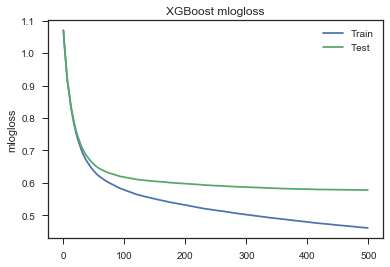

In [131]:
## xgboost
xgb2 = xgb.XGBClassifier(max_depth=10, n_estimators=500, learning_rate=0.06,objective="multi:softmax",
                         tree_method='auto',random_state=42,colsample_bytree=0.8,subsample=0.85,
                        eval_metric ="mlogloss",
                        gamma=0.2,reg_alpha=0.3,
                min_child_weight = 3)


eval_set = [(x_train[colneeded], x_train['damage_grade']), (x_valid[colneeded], x_valid['damage_grade'])]

kfold = StratifiedKFold(n_splits=10, random_state=7)

results = cross_val_score(xgb2, x_train[colneeded], x_train['damage_grade'], cv=kfold)

#xgb2.fit(x_train[colneeded], x_train['damage_grade'],early_stopping_rounds=120, eval_metric=["mlogloss"],eval_set=eval_set)


# retrieve performance metrics
results = xgb2.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
plt.ylabel('mlogloss')
plt.title('XGBoost mlogloss')
plt.show()

In [421]:
results['fi']

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,count_floors_pre_eq,987,1010,999,993,1000,1000,986,1011,999,998
1,age,1978,1996,2026,2064,1933,1985,2033,2005,1991,1930
2,area_percentage,2260,2151,2169,2189,2158,2198,2254,2148,2191,2152
3,height_percentage,1974,2054,2026,1997,2046,2045,2003,1979,2043,2013
4,has_superstructure_adobe_mud,585,631,591,579,588,546,554,597,583,580
5,has_superstructure_mud_mortar_stone,618,607,577,580,579,555,601,610,620,600
6,has_superstructure_stone_flag,500,470,511,508,483,480,491,518,473,530
7,has_superstructure_cement_mortar_stone,405,400,418,409,424,438,413,400,443,419
8,has_superstructure_mud_mortar_brick,454,468,475,473,503,491,433,452,469,468
9,has_superstructure_cement_mortar_brick,391,386,391,378,391,384,385,373,378,355


In [422]:
#results['test']

In [423]:
x['damage_grade'].unique()

array([1, 2, 0], dtype=int64)

In [76]:
predv=model.predict(x_valid[colneeded])

In [132]:
pred_xgb_val=xgb2.predict(x_valid[colneeded])

In [134]:
Counter(pred_xgb_val)

Counter({1: 1699, 2: 731, 0: 177})

In [77]:
predv[:4]

array([[0.02619455, 0.65869834, 0.3151071 ],
       [0.05930591, 0.75141536, 0.18927873],
       [0.03417759, 0.74040607, 0.22541635],
       [0.69240608, 0.24985218, 0.05774174]])

In [78]:
predv.argmax(axis=1).shape,len(x_valid)

((5213,), 5213)

In [79]:
len(predv),x_valid.shape

(5213, (5213, 61))

In [80]:
predv2=predv.argmax(axis=1)

In [81]:
#predv2=[p.argmax()+1 for p in predv]

In [82]:
Counter(predv2)

Counter({1: 3773, 0: 218, 2: 1222})

In [83]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [84]:
Counter(y_valid)

Counter({1: 2966, 0: 502, 2: 1745})

In [85]:
f1_score(y_valid, predv2, average='micro') 

0.705927488969883

In [135]:
f1_score(y_valid, pred_xgb_val, average='micro') 

0.7460682777138473

In [86]:
#f1_score(y_valid, predv2, average='micro')  ## reference 0.6044280725989025

In [87]:
testdata.shape

(86868, 62)

In [88]:
testdata[colneeded].head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
260601,17,596,11307,3,20,7,6,0,1,0,...,0,0,0,0,0,0,0,0,1,0
260602,6,141,11987,2,25,13,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
260603,22,19,10044,2,5,4,5,0,1,0,...,0,0,0,0,0,0,0,0,1,0
260604,26,39,633,1,0,19,3,0,0,0,...,0,0,0,0,0,0,0,0,1,0
260605,17,289,7970,3,15,8,7,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [89]:
pred_test=model.predict(testdata[colneeded]).argmax(axis=1) +1
#pred_test2=[p.argmax()+1 for p in pred_test]

In [137]:
pred_test_xgb=xgb2.predict(testdata[colneeded])


In [90]:
pred_test[:2]

array([3, 2], dtype=int64)

In [91]:
pred_test.shape

(86868,)

In [92]:
Counter(pred_test)

Counter({3: 19961, 2: 62946, 1: 3961})

In [93]:
submissiondf.shape

(86868, 2)

In [94]:
submissiondf.head()

,building_id,damage_grade
0,300051,1
1,99355,1
2,890251,1
3,745817,1
4,421793,1


In [138]:
submissiondf2=submissiondf.copy()

In [96]:
submissiondf2['damage_grade']=pred_test



In [142]:
## using xgb
submissiondf2['damage_grade']=pred_test_xgb
submissiondf2['damage_grade_lgb']=pred_test


In [143]:
submissiondf2.head()

,building_id,damage_grade,damage_grade_lgb
0,300051,2,3
1,99355,1,2
2,890251,1,2
3,745817,0,1
4,421793,2,3


In [141]:
submissiondf2.to_csv("D:/hackathon/drivendata/earthquakprediction/sub_xgb1.csv",index=None)